# Machine Learning for Texts (NLP)

## Introduction

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

**Data Description**
- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

**Plan**
- Load and pre-process text data.
- Conduct exploratory data analysis and check for class imbalance.
- Transform text to vectors.
- Trained and test logistic regression, gradient boosting and tree-based models with some hyperparameter tuning.
- Test models on my own set of reviews.
- Compare findings.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Load Data

In [3]:
df = pd.read_csv('/Users/laceymalarky/git_projects/python-exercises/TripleTen/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df.duplicated().sum()

0

## EDA

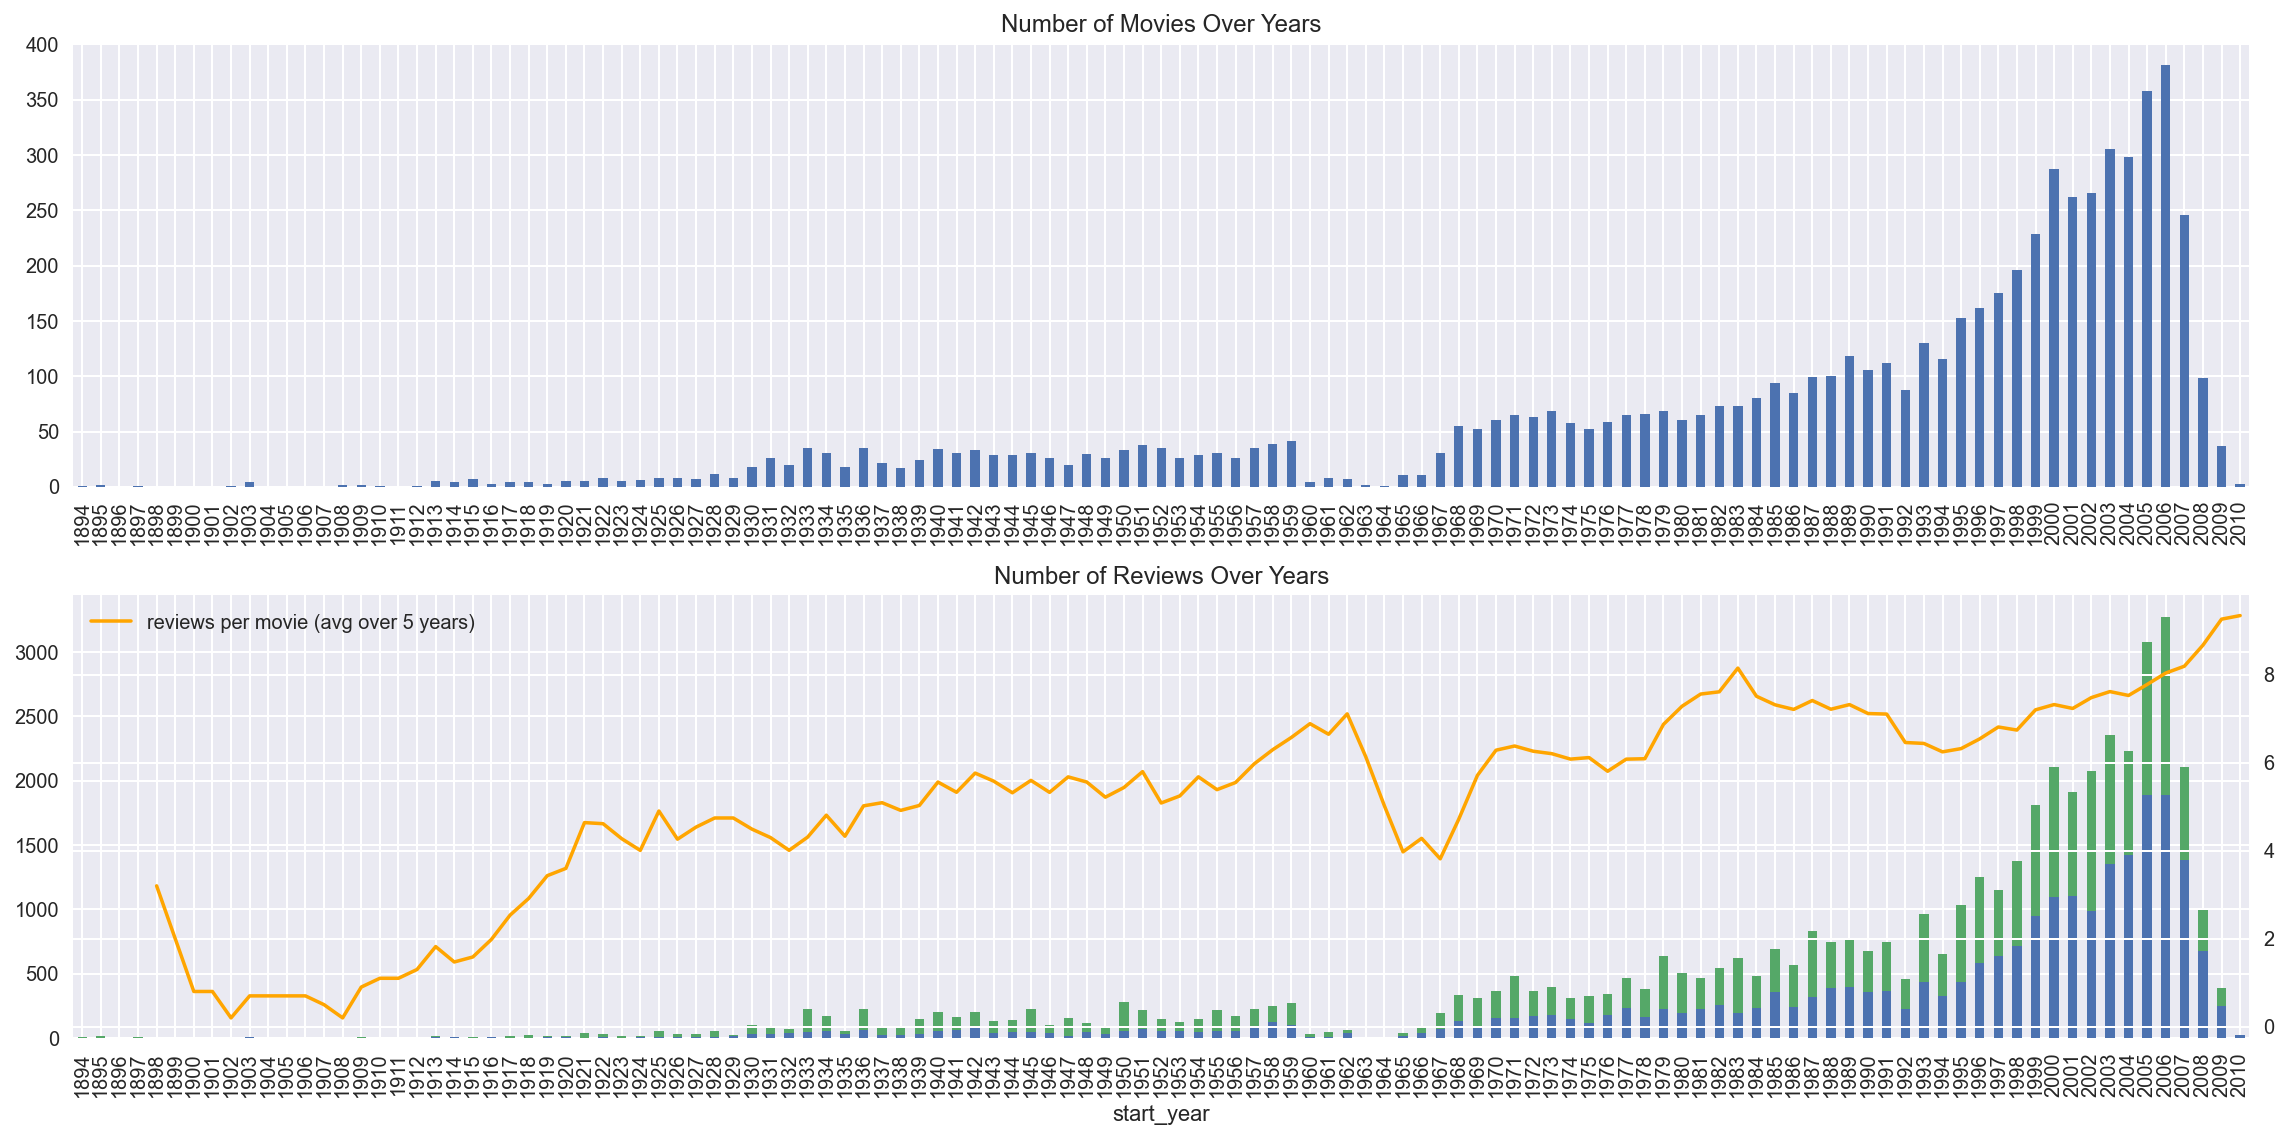

In [8]:
# Plot number of movies and reviews by year
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), dft1.index.max()+1)).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), dft2.index.max()+1)).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), dft2.index.max()+1)).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

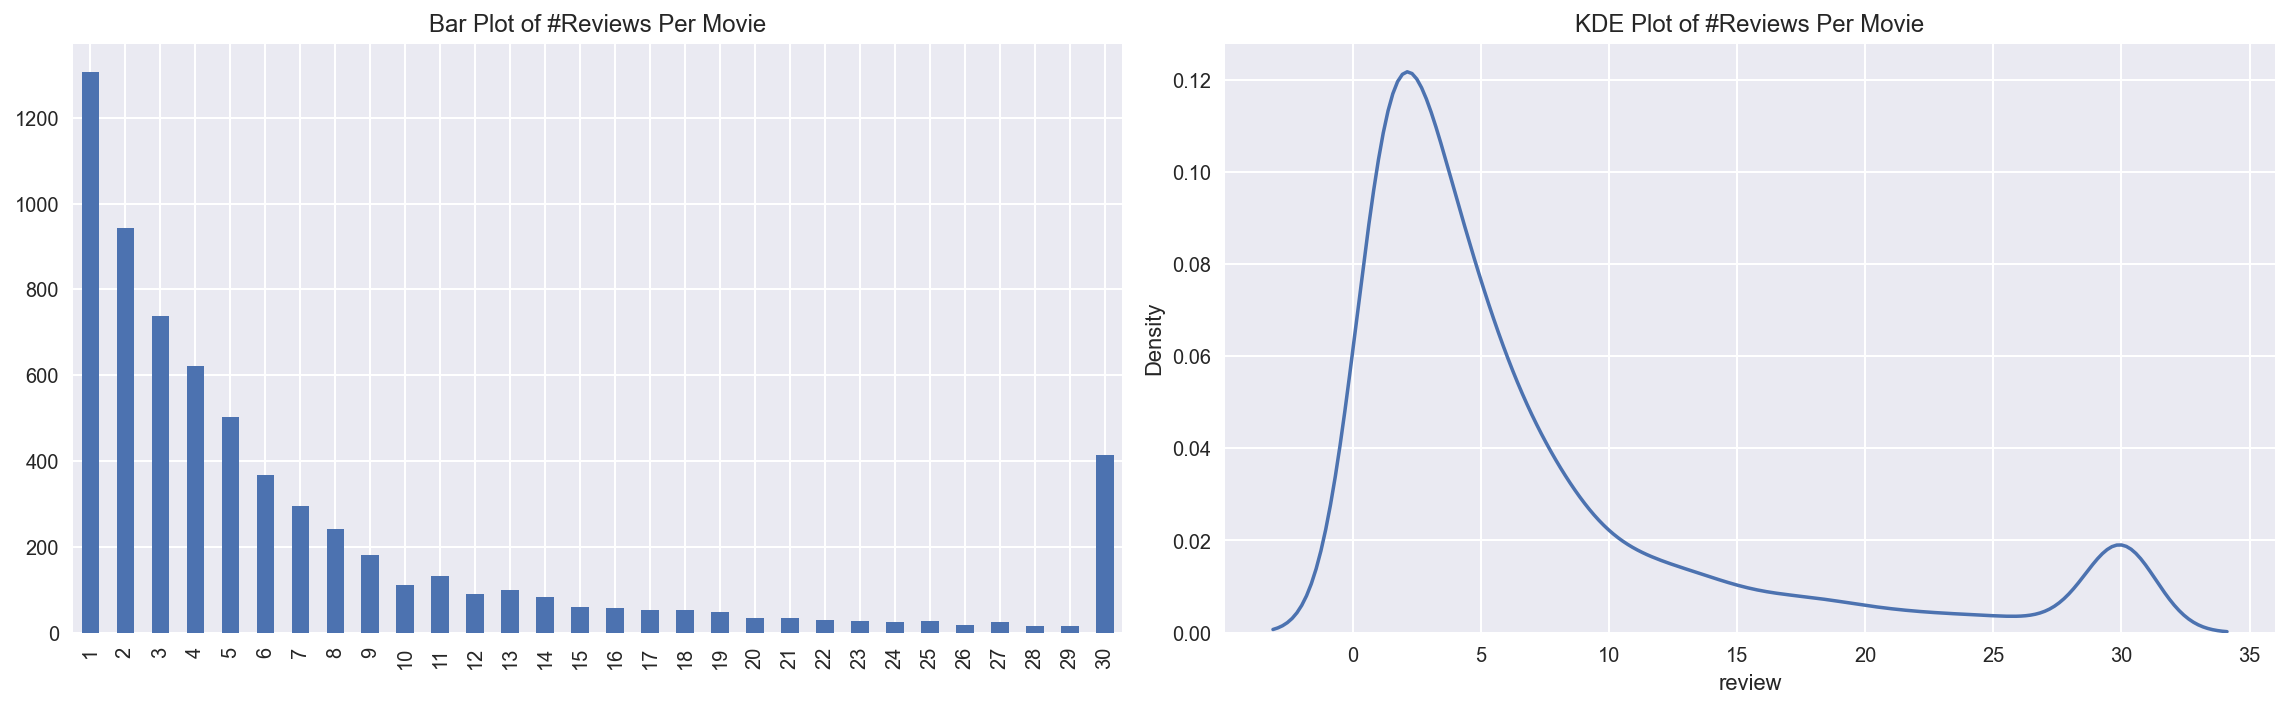

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [10]:
df['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

Classes are balanced

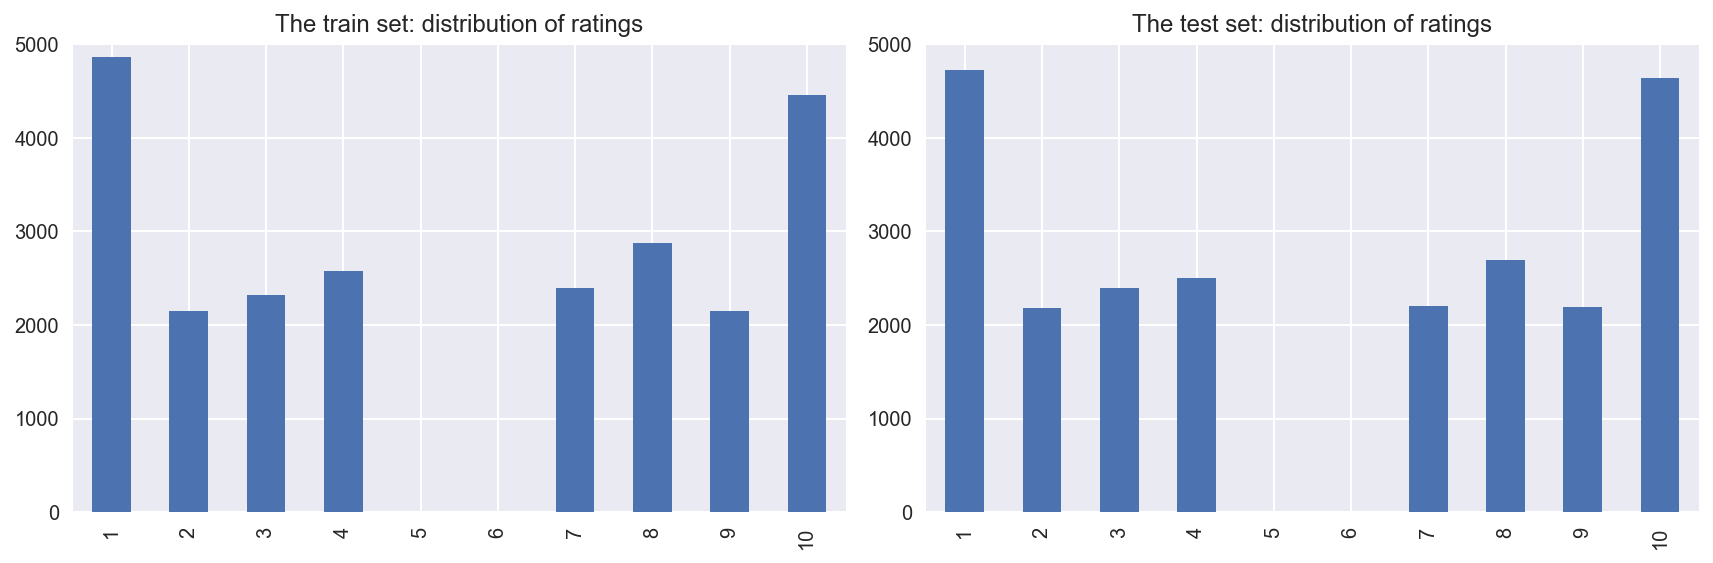

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

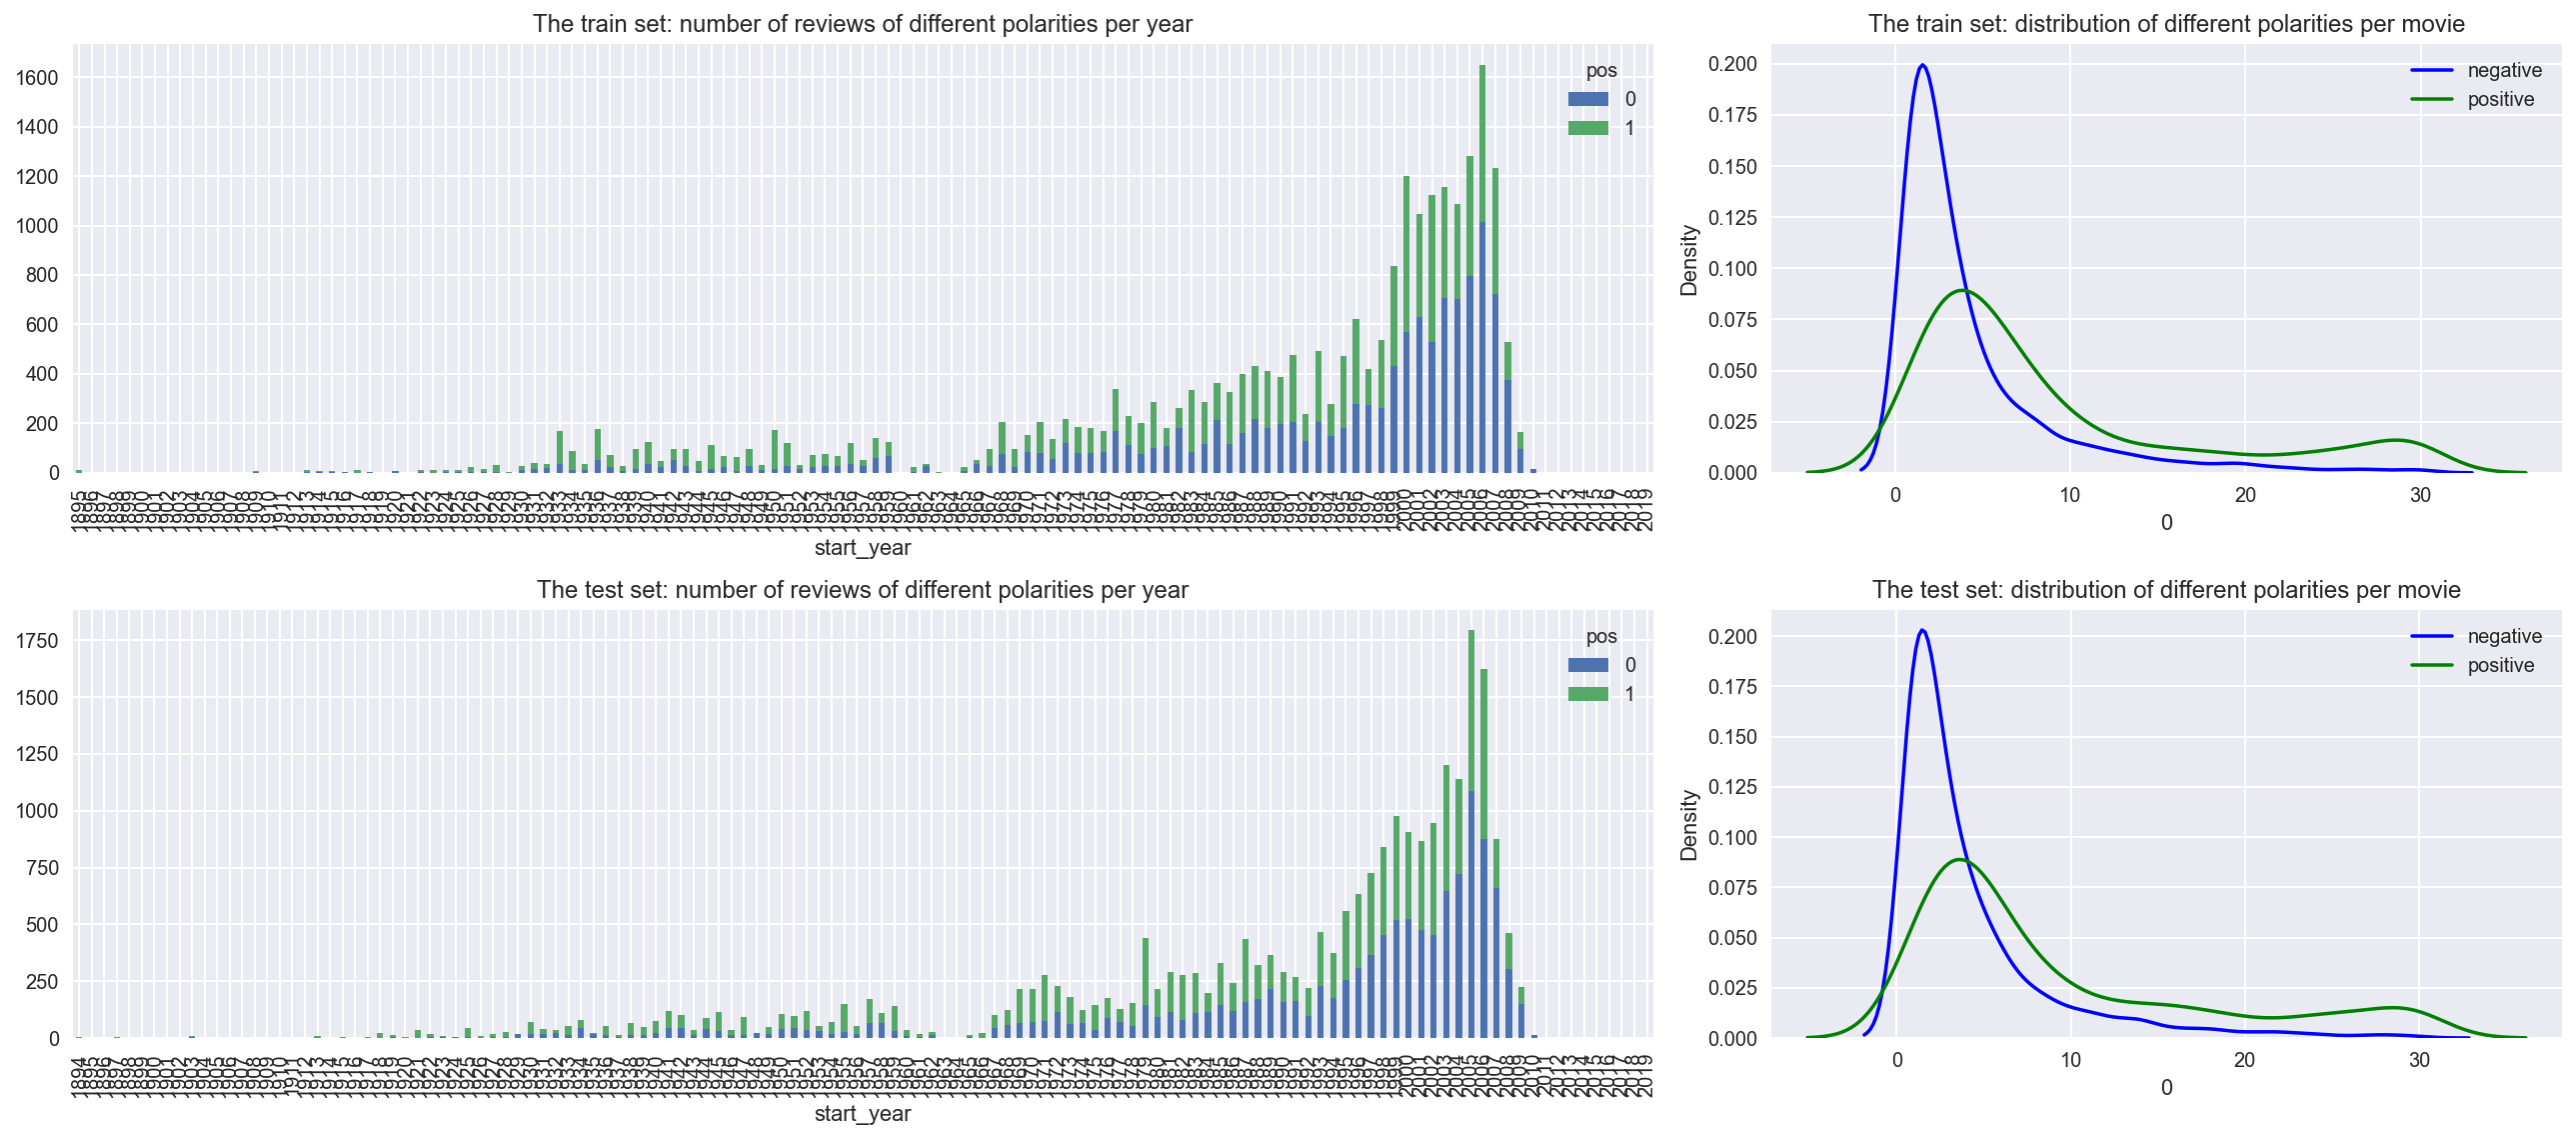

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative',  ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Conclusions:**
- The training and test sets contain more negative reviews than positive: classes are imbalanced.
- There is a spike in movie reviews starting in 1995.

## Evaluation Procedure

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    '''
    Plots F1, ROC-AUC Curve and PRC Curve for training and test sets.
    '''
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

In [14]:
import re

# Convert to lowercase and remove all characters except letters, apostrophes, and spaces
def normalize_text(text):
    text_cleaned = []
    for row in text:
        cleaned = row.lower()
        cleaned = re.sub(r"[^a-zA-Z']", " ", cleaned)
        cleaned = cleaned.split()
        cleaned = ' '.join(cleaned)
        text_cleaned.append(cleaned)
    return text_cleaned

In [15]:
df['review_norm'] = normalize_text(df['review'])

In [16]:
df['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

In [17]:
df.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx',
       'review_norm'],
      dtype='object')

## Train/Test Split

In [18]:
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

X_train = df_train['review_norm']
X_test = df_test['review_norm']

y_train = df_train['pos']
y_test = df_test['pos']

print(df_train.shape)
print(df_test.shape)

(23796, 18)
(23535, 18)


## Model Comparisons

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


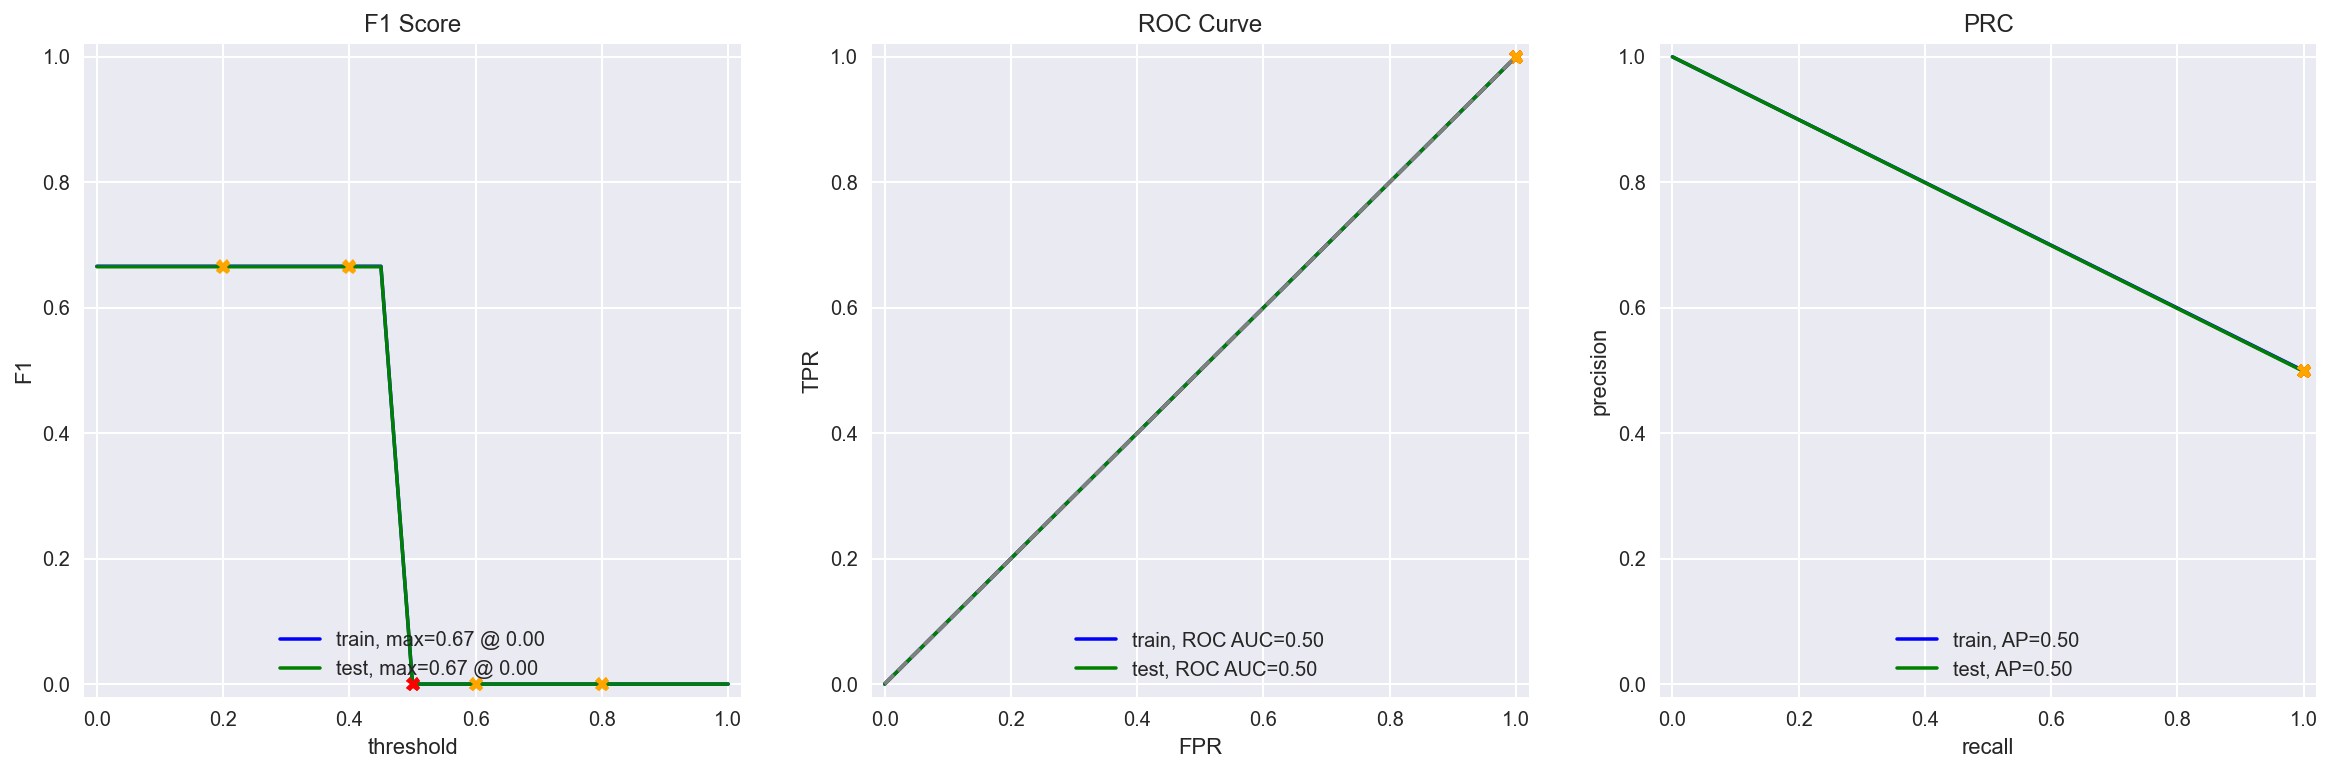

In [19]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(random_state=0)
dummy_clf.fit(X_train, y_train)

evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

### NLTK and TF-IDF

**NLTK**

In [20]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() 

def text_preprocessing_nltk(text):
    review_lemmas = []
    for row in text:      
        tokens = word_tokenize(row)
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        review_lemmas.append(" ".join(lemmas))
    return review_lemmas

In [21]:
df_train['review_lemmas_nltk'] = text_preprocessing_nltk(X_train)
df_test['review_lemmas_nltk'] = text_preprocessing_nltk(X_test)

In [22]:
# Remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

**TF-IDF**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_tfidf_1 = TfidfVectorizer(stop_words=stop_words)
  
print("Preprocessing training data...")
train_preprocessed_1 = count_tfidf_1.fit_transform(df_train.review_lemmas_nltk)

print("Preprocessing test data...")
test_preprocessed_1 = count_tfidf_1.transform(df_test.review_lemmas_nltk)

Preprocessing training data...
Preprocessing test data...


#### Model 1 - LR

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=0)

parameters = {'C': [0.1, 1, 10, 100, 1000]}

print("Grid search for logistic regression")
model_1 = GridSearchCV(lr_classifier, parameters, cv=3, verbose=1)
model_1.fit(train_preprocessed_1, y_train)

print("Best LR parameters:")
print(model_1.best_params_)

model_1_predictions = model_1.predict(test_preprocessed_1)
print("Best LR Accuracy:", np.mean(model_1_predictions == y_test))

Grid search for logistic regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/laceymalarky/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laceymalarky/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Best LR parameters:
{'C': 1}
Best LR Accuracy: 0.8798385383471425


**Evaluation**

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


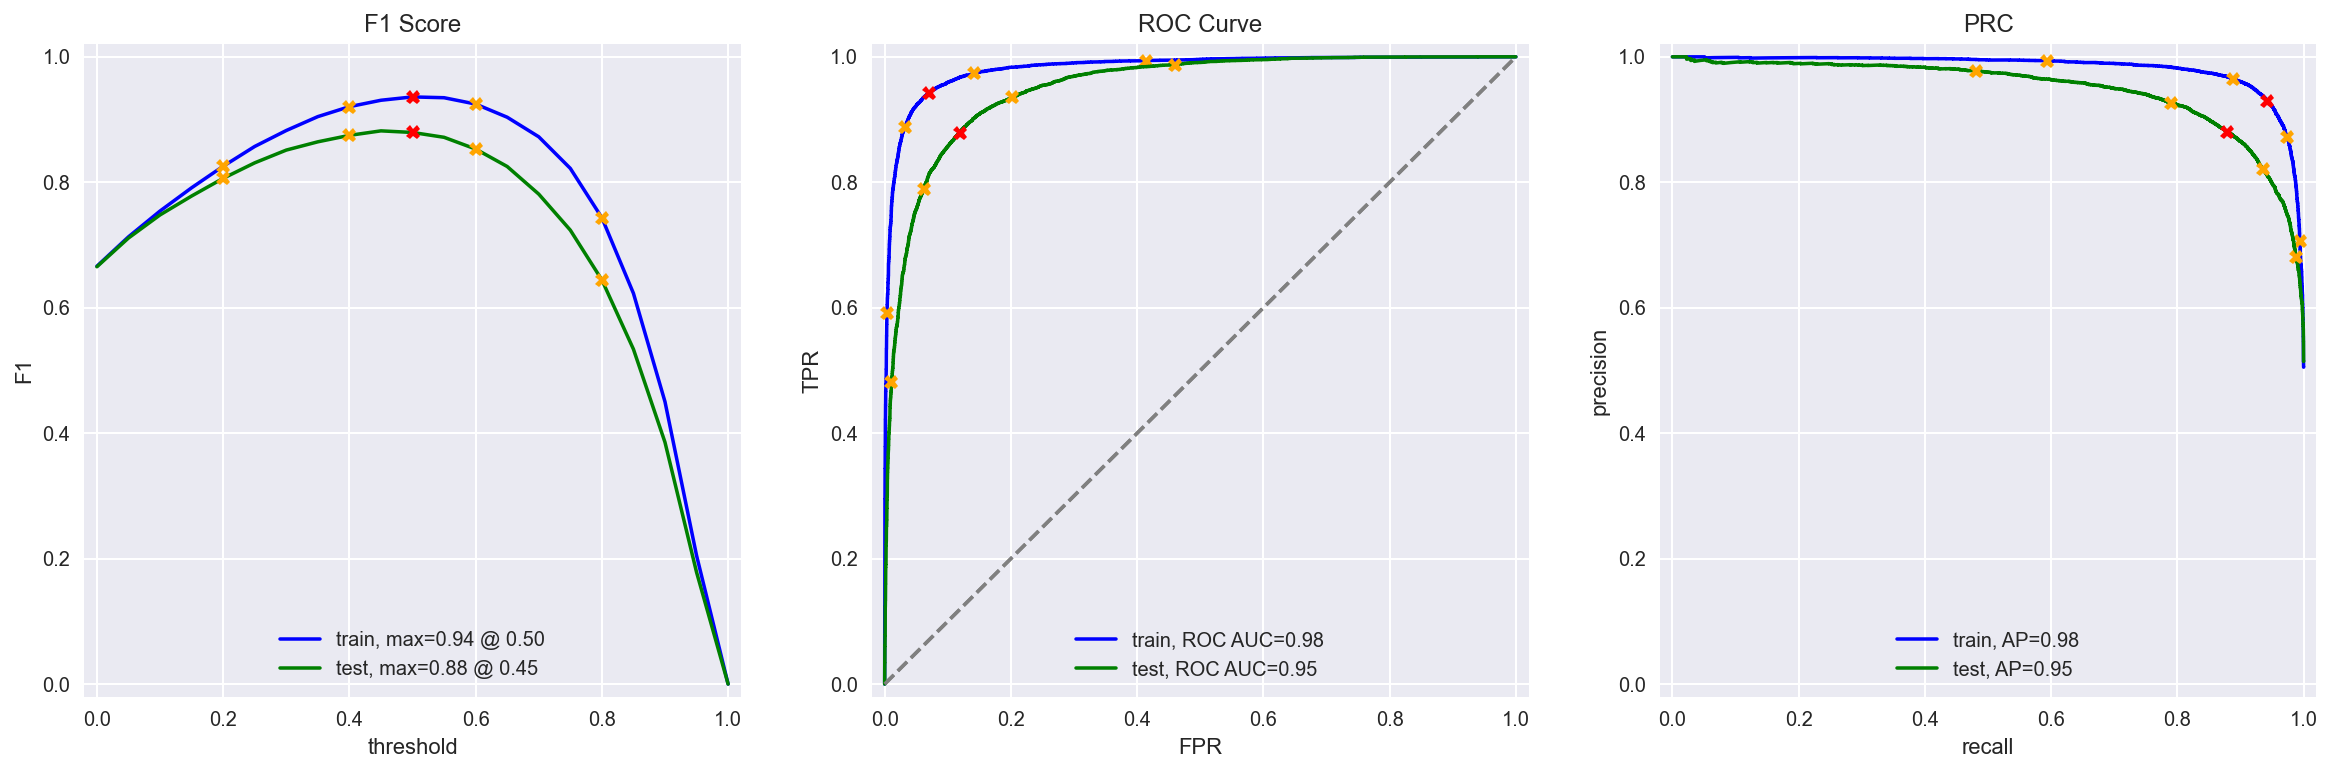

In [26]:
evaluate_model(model_1, train_preprocessed_1, y_train, test_preprocessed_1, y_test)

#### Model 2 - DT

In [27]:
%%time
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=0)

parameters = {'max_depth': [5, 10, 15, 20, None]}

print("Grid search for decision tree classifier")
model_2 = GridSearchCV(dt_classifier, parameters, cv=3, verbose=1)
model_2.fit(train_preprocessed_1, y_train)

print("Best DT parameters:")
print(model_2.best_params_)

model_2_predictions = model_2.predict(test_preprocessed_1)
print("Best DT Accuracy:", np.mean(model_2_predictions == y_test))

Grid search for decision tree classifier
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best DT parameters:
{'max_depth': 15}
Best DT Accuracy: 0.730444019545358
CPU times: user 1min 8s, sys: 128 ms, total: 1min 8s
Wall time: 1min 8s


          train  test
Accuracy   0.82  0.73
F1         0.83  0.75
APS        0.86  0.68
ROC AUC    0.89  0.76


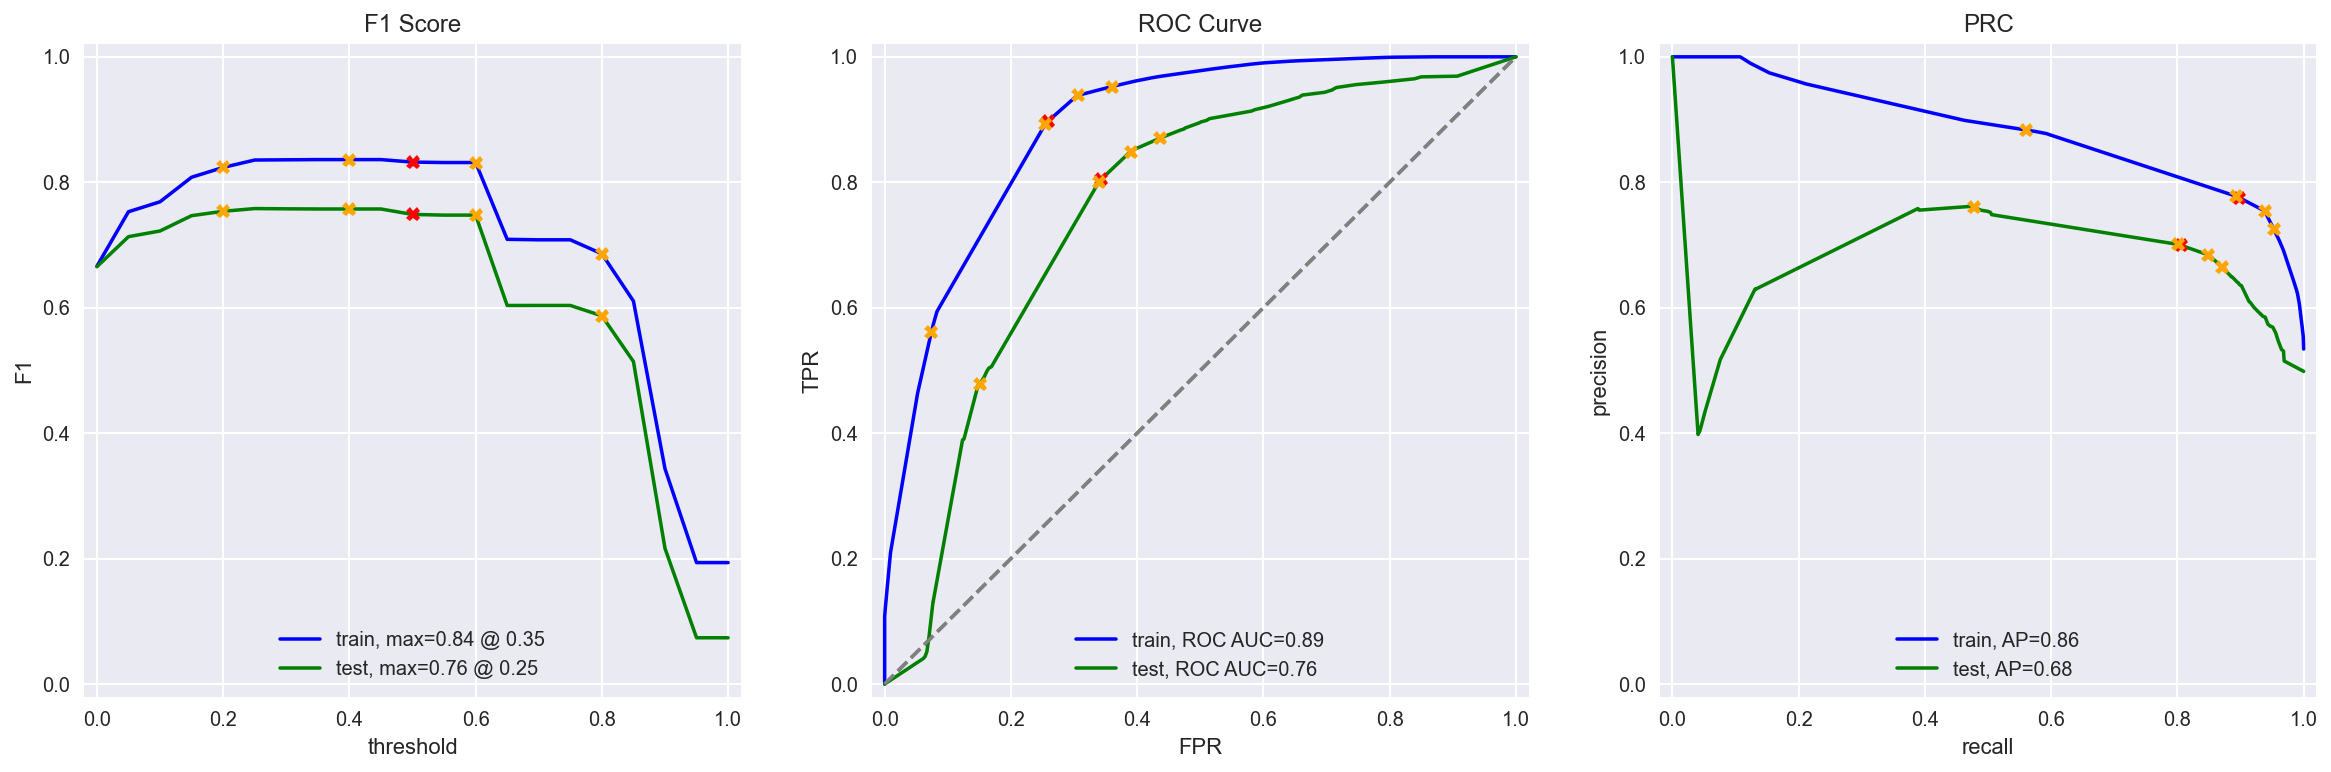

In [28]:
evaluate_model(model_2, train_preprocessed_1, y_train, test_preprocessed_1, y_test)

#### Model 3 - RF

In [29]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=0)

parameters = {'n_estimators' : [100, 150]}

print("Grid search for random forest classifier")
model_3 = GridSearchCV(rf_classifier, parameters, cv=3, verbose=1)
model_3.fit(train_preprocessed_1, y_train)

print("Best RF parameters:")
print(model_3.best_params_)

model_3_predictions = model_3.predict(test_preprocessed_1)
print("Best RF Accuracy:", np.mean(model_3_predictions == y_test))

Grid search for random forest classifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best RF parameters:
{'n_estimators': 150}
Best RF Accuracy: 0.85247503717867
CPU times: user 3min 37s, sys: 382 ms, total: 3min 37s
Wall time: 3min 37s


          train  test
Accuracy    1.0  0.85
F1          1.0  0.85
APS         1.0  0.92
ROC AUC     1.0  0.93


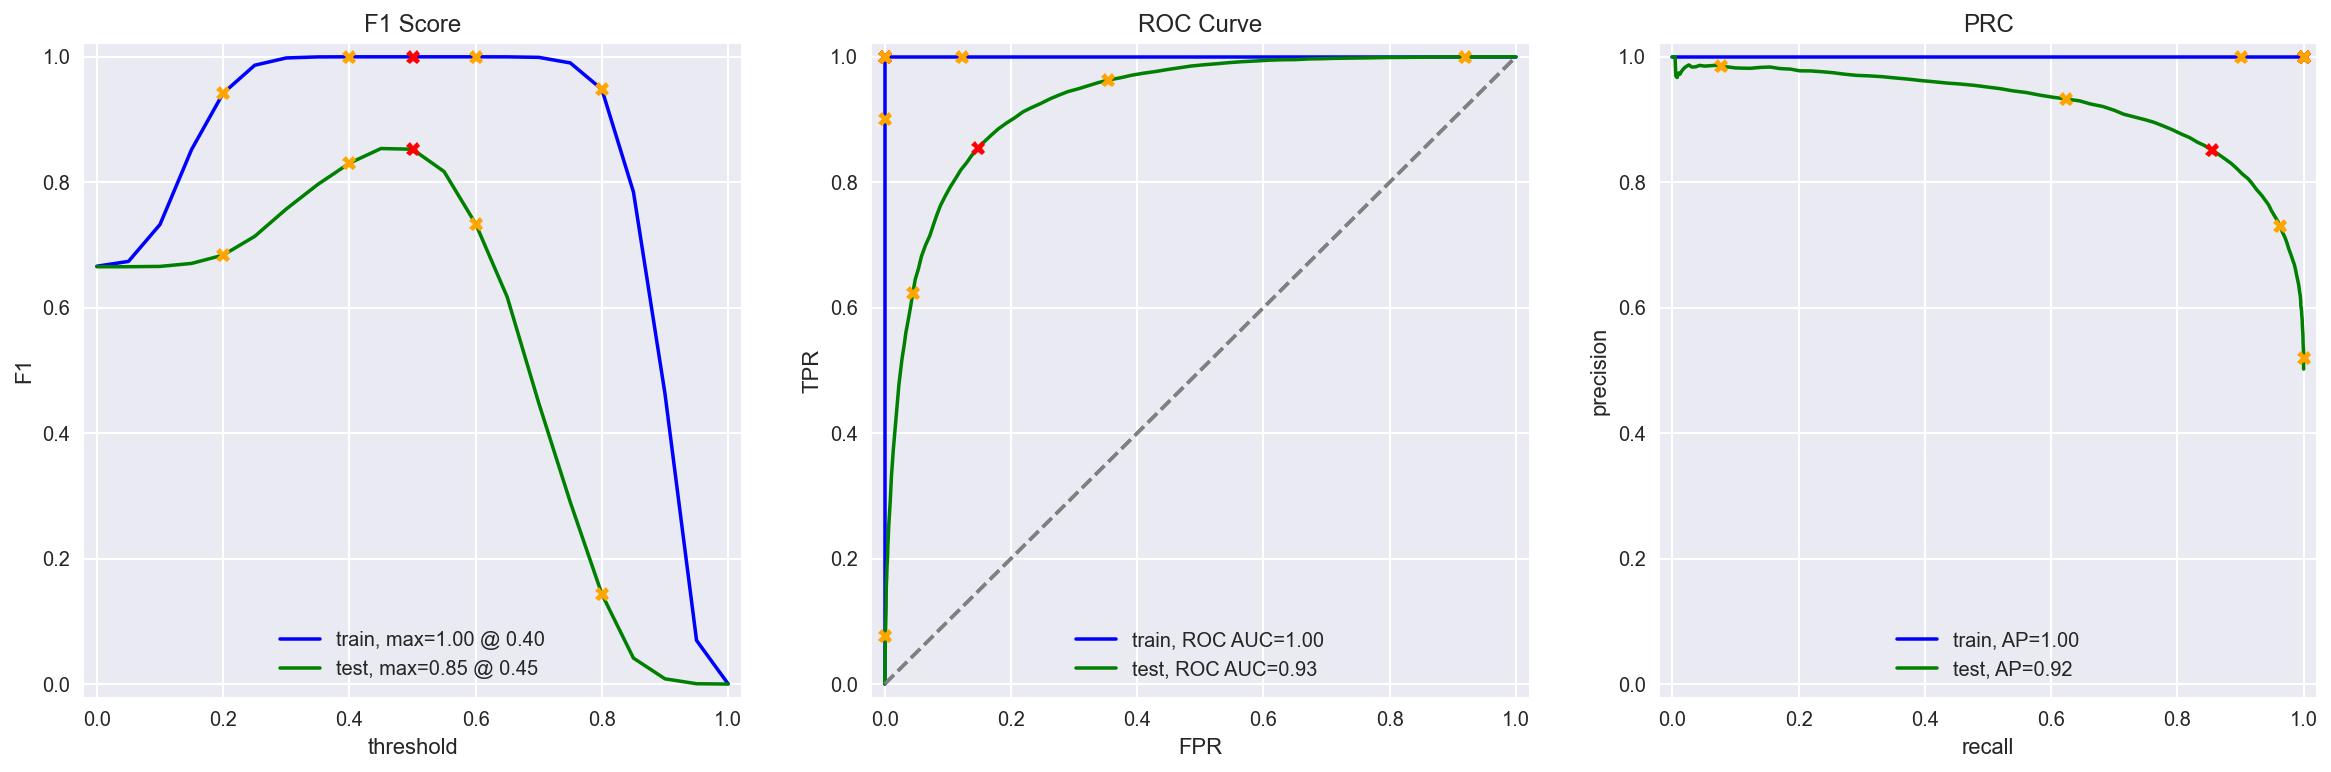

In [30]:
evaluate_model(model_3, train_preprocessed_1, y_train, test_preprocessed_1, y_test)

### spaCy and TF-IDF

**spaCy**

In [31]:
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

In [32]:
def text_preprocessing_spacy(text):
    tokens = []
    for row in text:

        doc = nlp(row)

        lemmas = [token.lemma_ for token in doc if not token.is_stop]
        lemmas = " ".join(lemmas)
        tokens.append(lemmas)
    return tokens

In [33]:
%%time
df_train['review_lemmas_spacy'] = text_preprocessing_spacy(X_train)
df_test['review_lemmas_spacy'] = text_preprocessing_spacy(X_test)

CPU times: user 9min 39s, sys: 1.28 s, total: 9min 40s
Wall time: 10min 31s


**TF-IDF**

In [34]:
count_tfidf_2 = TfidfVectorizer(stop_words=stop_words)

print("Preprocessing training data...")
train_preprocessed_2 = count_tfidf_2.fit_transform(df_train.review_lemmas_spacy)

print("Preprocessing test data...")
test_preprocessed_2 = count_tfidf_2.transform(df_test.review_lemmas_spacy)

Preprocessing training data...
Preprocessing test data...


#### Model 4 - LR

In [35]:
parameters = {'C': [0.1, 1, 10, 100, 1000]}

lr_classifier = LogisticRegression(random_state=0)

print("Grid search for logistic regression")
model_4 = GridSearchCV(lr_classifier, parameters, cv=3, verbose=1)
model_4.fit(train_preprocessed_2, y_train)

print("Best LR parameters:")
print(model_4.best_params_)

model_4_predictions = model_4.predict(test_preprocessed_2)
print("Best LR Accuracy:", np.mean(model_4_predictions == y_test))

Grid search for logistic regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/laceymalarky/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laceymalarky/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Best LR parameters:
{'C': 1}
Best LR Accuracy: 0.8744848098576588


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


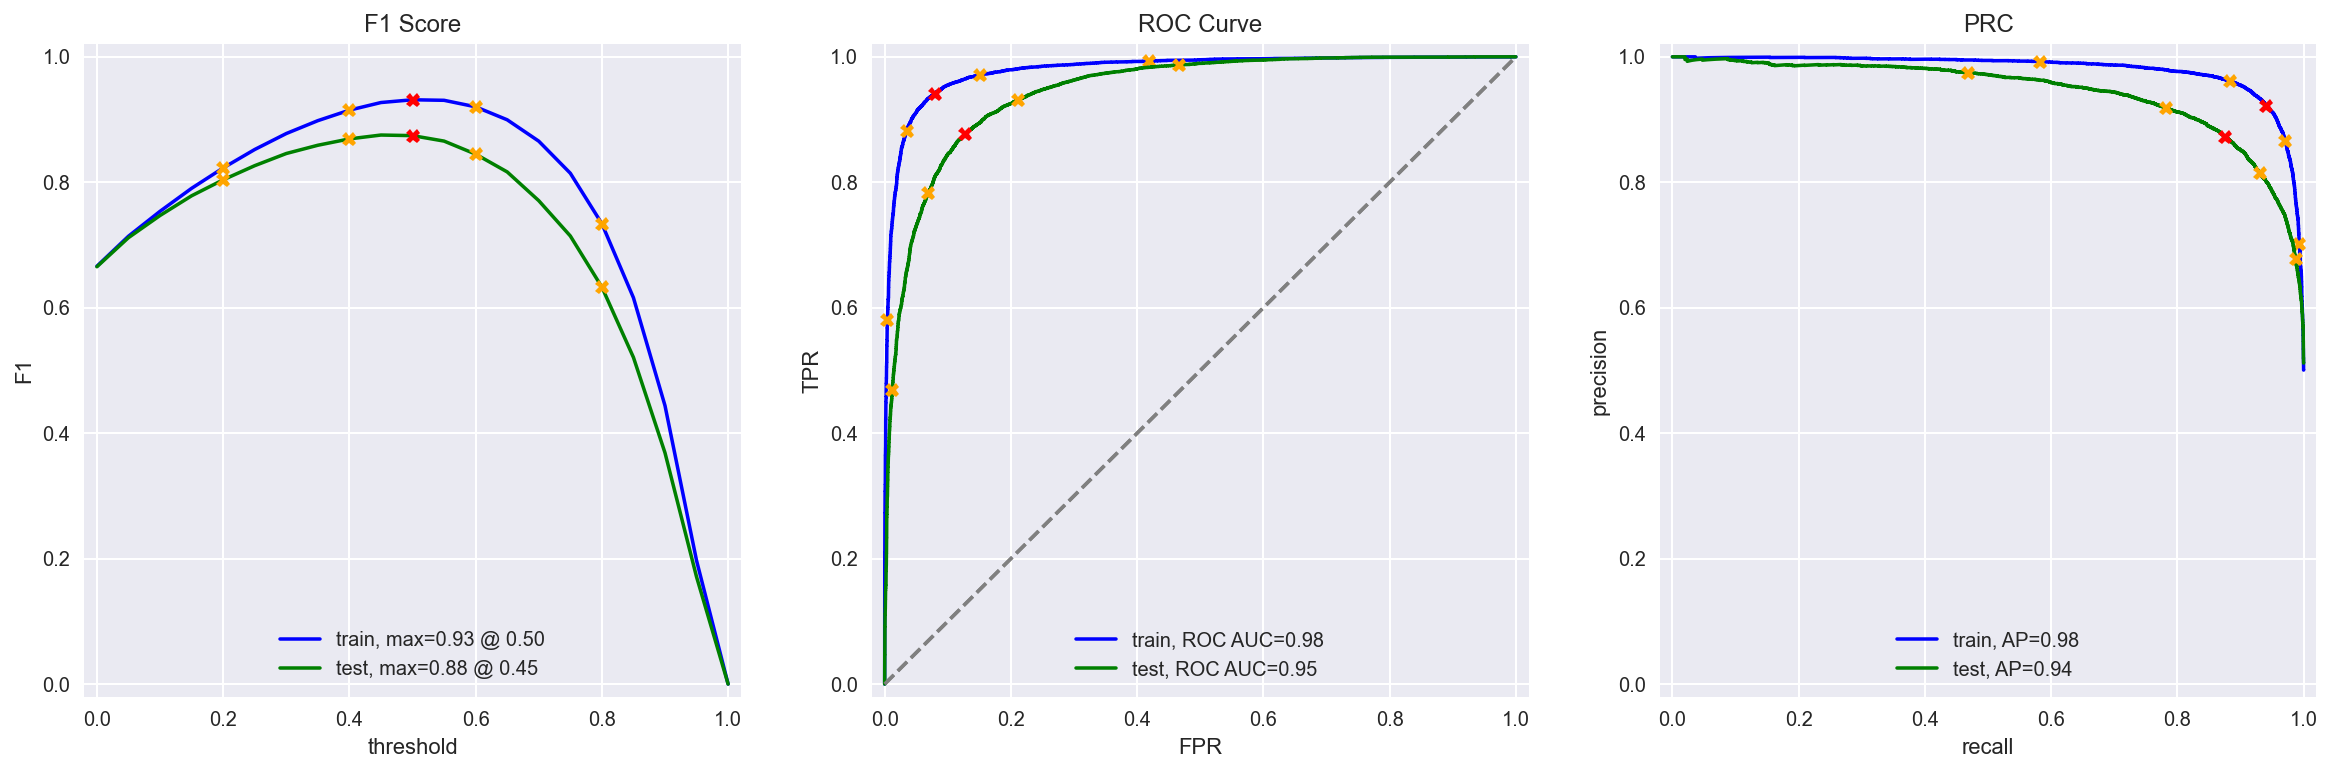

In [36]:
evaluate_model(model_4, train_preprocessed_2, y_train, test_preprocessed_2, y_test)

#### Model 5 - DT

In [37]:
%%time
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=0)

parameters = {'max_depth': [5, 10, 15, 20, None]}

print("Grid search for decision tree classifier")
model_5 = GridSearchCV(dt_classifier, parameters, cv=3, verbose=1)
model_5.fit(train_preprocessed_2, y_train)

print("Best DT parameters:")
print(model_5.best_params_)

model_5_predictions = model_5.predict(test_preprocessed_2)
print("Best DT Accuracy:", np.mean(model_5_predictions == y_test))

Grid search for decision tree classifier
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best DT parameters:
{'max_depth': 20}
Best DT Accuracy: 0.7379222434671765
CPU times: user 1min, sys: 103 ms, total: 1min
Wall time: 1min


          train  test
Accuracy   0.86  0.74
F1         0.87  0.76
APS        0.90  0.67
ROC AUC    0.92  0.74


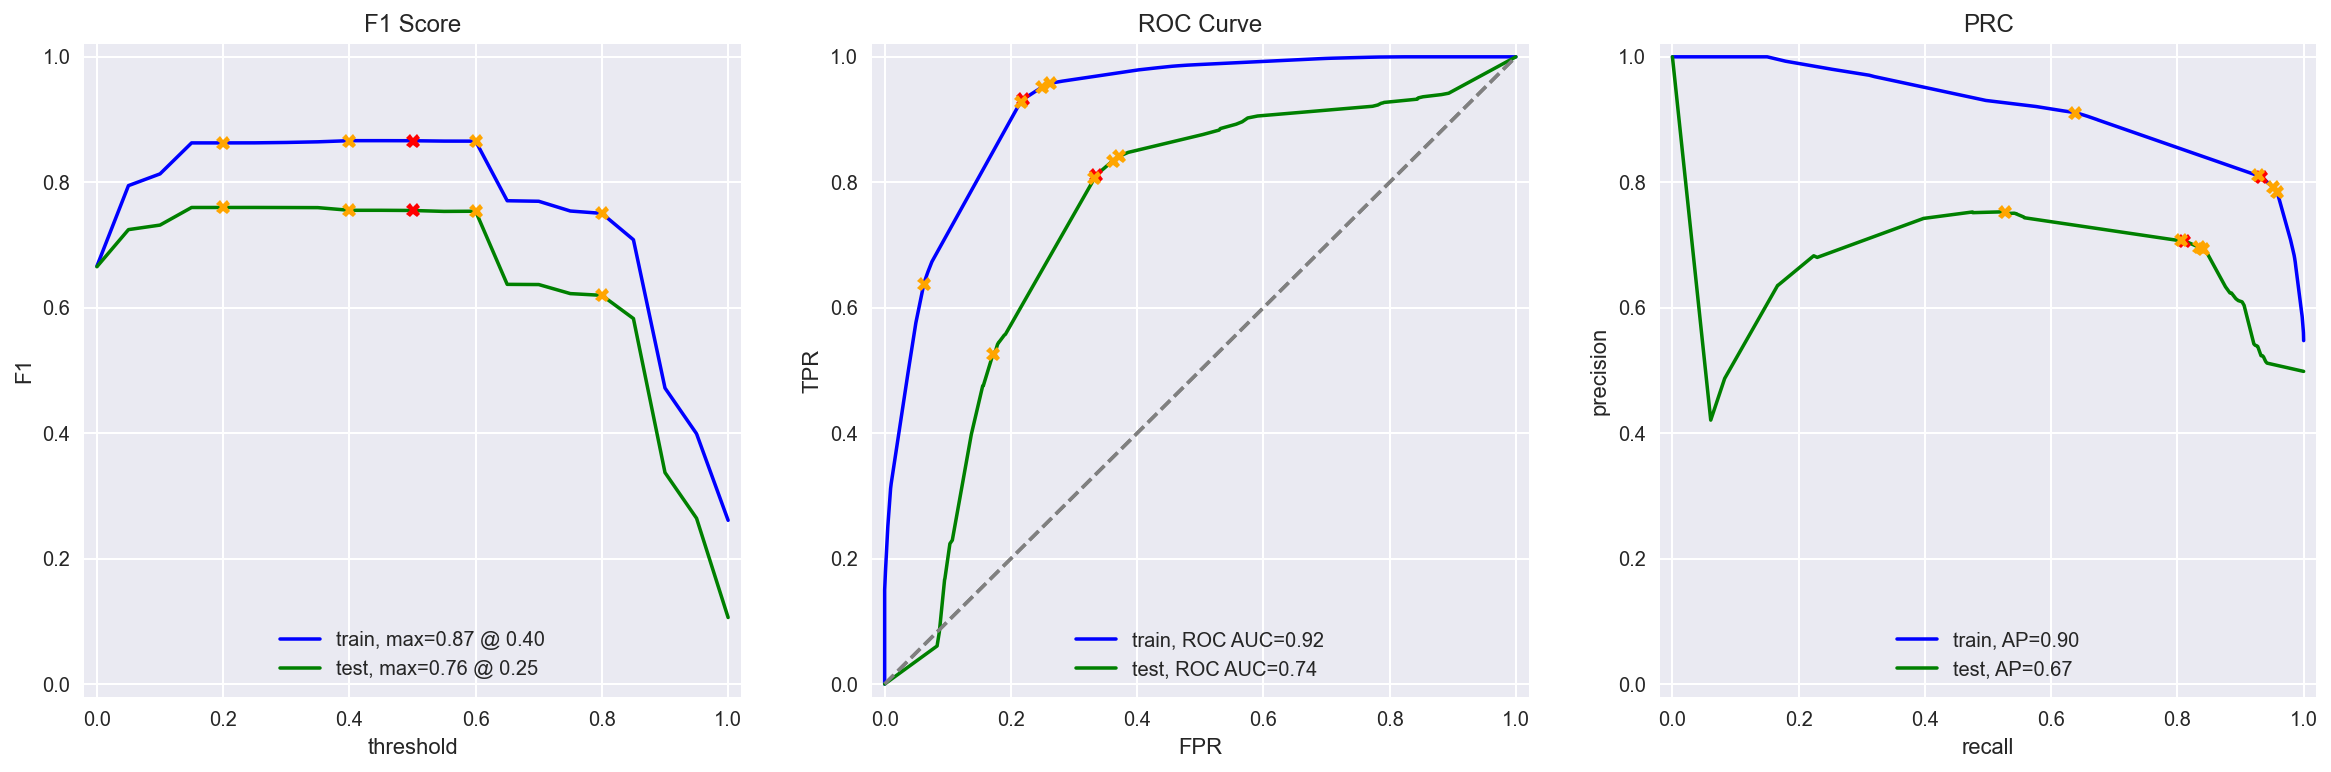

In [38]:
evaluate_model(model_5, train_preprocessed_2, y_train, test_preprocessed_2, y_test)

#### Model 6 - RF

In [39]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=0)

parameters = {'n_estimators' : [100, 150]}

print("Grid search for random forest classifier")
model_6 = GridSearchCV(rf_classifier, parameters, cv=3, verbose=1)
model_6.fit(train_preprocessed_2, y_train)

print("Best RF parameters:")
print(model_6.best_params_)

model_6_predictions = model_6.predict(test_preprocessed_2)
print("Best RF Accuracy:", np.mean(model_6_predictions == y_test))

Grid search for random forest classifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best RF parameters:
{'n_estimators': 150}
Best RF Accuracy: 0.8480560866794137
CPU times: user 3min 25s, sys: 395 ms, total: 3min 25s
Wall time: 3min 25s


          train  test
Accuracy    1.0  0.85
F1          1.0  0.85
APS         1.0  0.92
ROC AUC     1.0  0.93


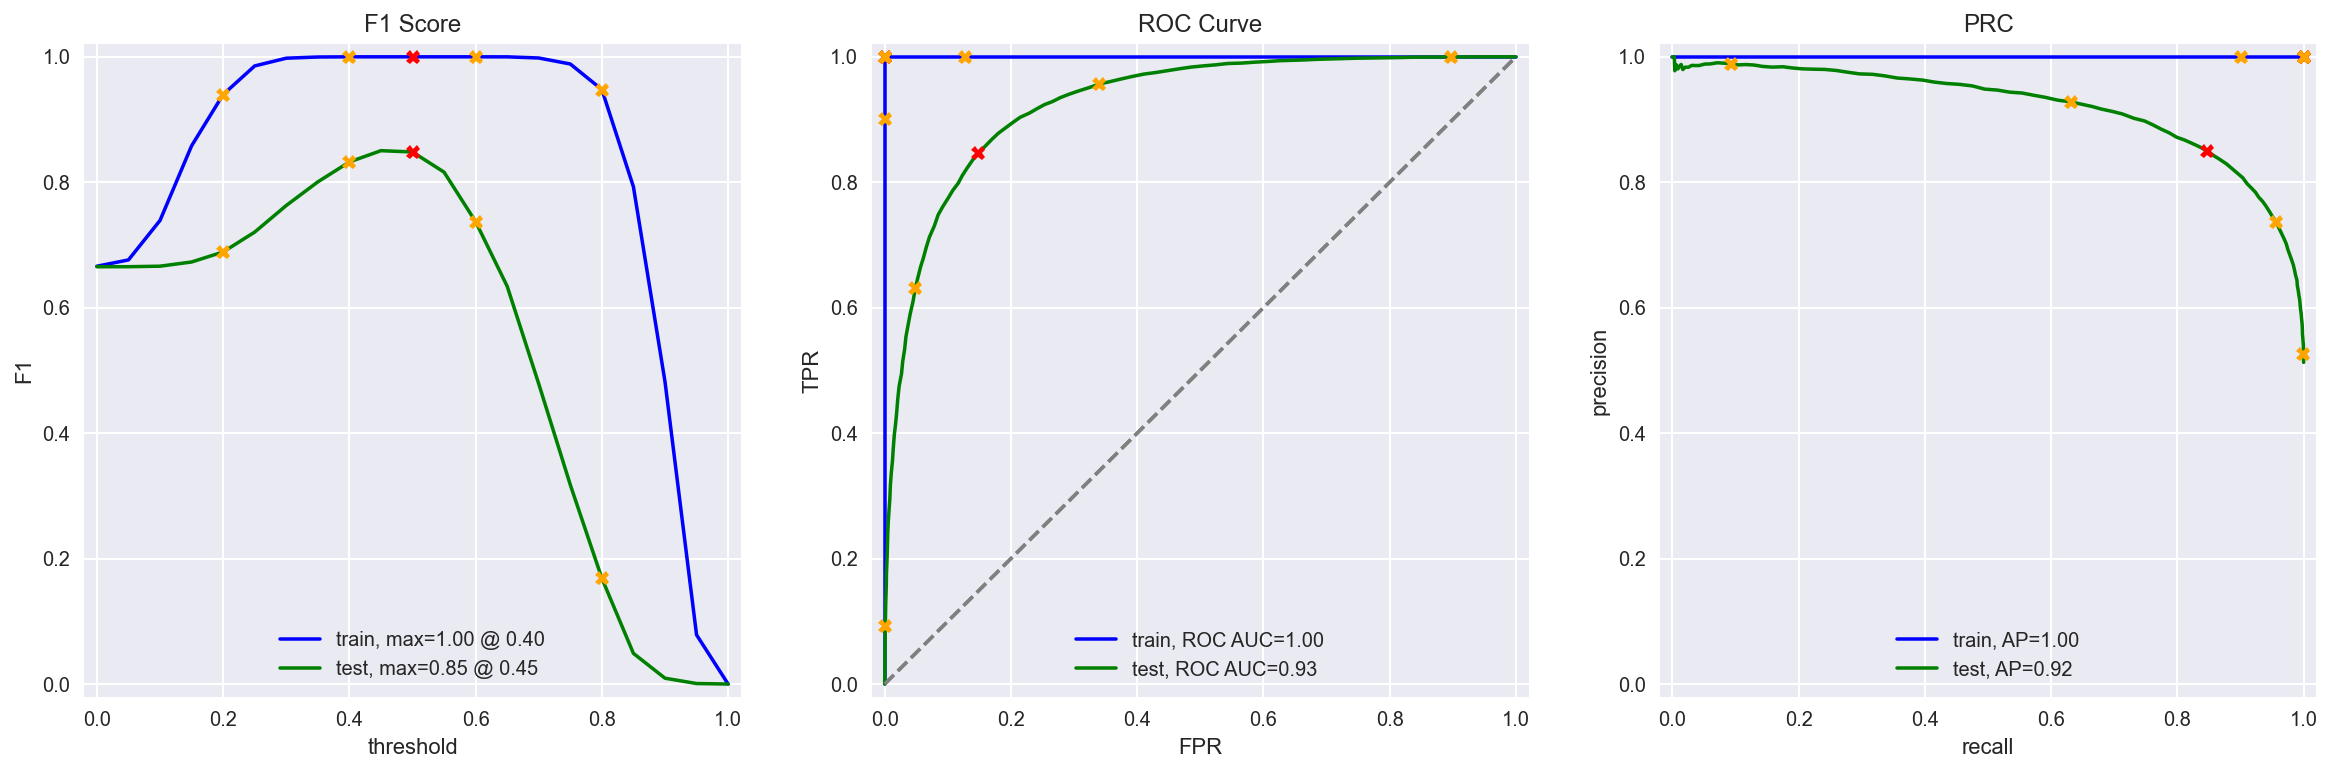

In [40]:
evaluate_model(model_6, train_preprocessed_2, y_train, test_preprocessed_2, y_test)

#### Model 7 - XGBoost

In [41]:
from xgboost import XGBClassifier

# Initialize model
model_xgb = XGBClassifier(random_state=0)

In [42]:
%%time
# Grid Search for hyperparameter tuning
grid = {'max_depth': [2, 5],
        'n_estimators': [50, 100]}

model_7 = GridSearchCV(model_xgb, grid)
model_7.fit(train_preprocessed_2, y_train, eval_set=[(train_preprocessed_2, y_train), (test_preprocessed_2, y_test)], verbose=False)

print('Best XGBoost parameters:')
print(model_7.get_params()['estimator'])

model_7_predictions = model_7.predict(test_preprocessed_2)
print("Best XGBoost Accuracy:", np.mean(model_7_predictions == y_test))

Best XGBoost parameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)
Best XGBoost Accuracy: 0.8443169747185043
CPU times: user 21min 44s, sys: 55.4 s, total: 22min 39s
Wall time: 2min 58s


          train  test
Accuracy   0.92  0.84
F1         0.92  0.85
APS        0.98  0.92
ROC AUC    0.98  0.93


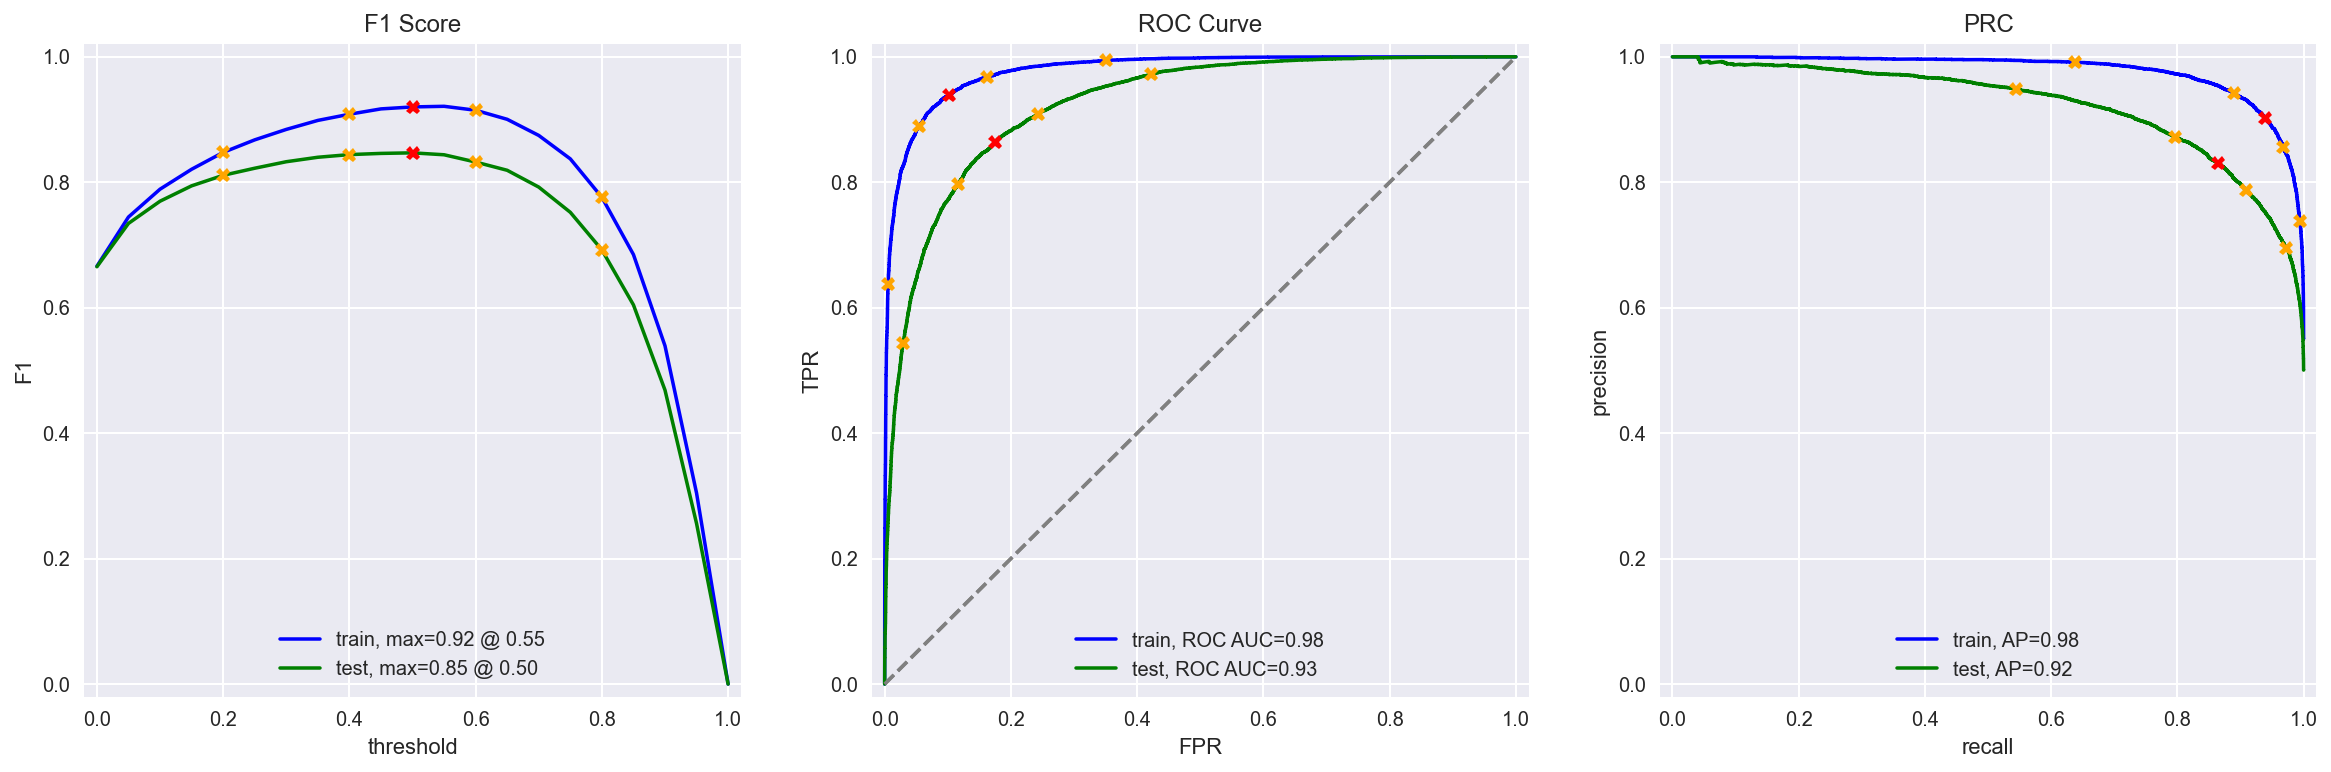

In [43]:
evaluate_model(model_7, train_preprocessed_2, y_train, test_preprocessed_2, y_test)

### Conclusions
Models in descending order of F1 score:
   - Logistic Regression (NLTK), F1 = 0.88
   - Logistic Regression (spaCy), F1 = 0.87
   - Random Forest (NLTK), F1 = 0.85
   - Random Forest (spaCy), F1 = 0.85
   - XGBoost (spaCy), F1 = 0.85
   - Decision Tree (spaCy), F1 = 0.76
   - Decision Tree (NLTK), F1 = 0.75

## My Reviews
Compare the top 4 models from above using a new set of test reviews (models 1, 4, 3, 6)

In [44]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'This movie was surprisingly intellectually stimulating.'
], columns=['review'])

my_reviews['review_norm'] = normalize_text(my_reviews['review'])

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,This movie was surprisingly intellectually sti...,this movie was surprisingly intellectually sti...


In [45]:
texts = my_reviews['review_norm']

### Model 1 (NLTK, TF-IDF and LR)

In [46]:
my_reviews_pred_prob = model_1.predict_proba(count_tfidf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn't expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.63:  this movie was surprisingly intellectually stimulating


### Model 4 (spaCy, TF-IDF and LR)

In [47]:
my_reviews_pred_prob = model_4.predict_proba(count_tfidf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.42:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.44:  i didn't expect the reboot to be so good writers really cared about the source material
0.56:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.11:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.60:  this movie was surprisingly intellectually stimulating


### Model 3 (NLTK, TF-IDF and RF)

In [48]:
my_reviews_pred_prob = model_3.predict_proba(count_tfidf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.71:  i did not simply like it not my kind of movie
0.70:  well i was bored and felt asleep in the middle of the movie
0.83:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.71:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.33:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.86:  this movie was surprisingly intellectually stimulating


### Model 6 (spaCy, TF-IDF and XGBoost)

In [49]:
my_reviews_pred_prob = model_6.predict_proba(count_tfidf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.41:  well i was bored and felt asleep in the middle of the movie
0.69:  i was really fascinated with the movie
0.73:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.73:  i didn't expect the reboot to be so good writers really cared about the source material
0.55:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.39:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.71:  this movie was surprisingly intellectually stimulating


## Conclusions

- Logistic Regression using NLTK for tokenization and lemmatization performed the best in terms of F1 score (0.87)
- When comparing the best models on 'my reviews', the predictions using spaCy are more accurate than those using NLTK even though the models F1/accuracy scores are similar
- The Logistic Regression models' prediction probabilities show that they are better at correctly identifying the sentiment of the review when compared to RF/XGBoost, and the spaCy LR model was the best at detecting negative reviews.